In [ ]:

# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# EDA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd

# Adjust path & filename depending on dataset
df = pd.read_csv("/kaggle/input/uber-ride-analytics-dashboard/ncr_ride_bookings.csv")
df.head()


In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

# 1.Explore Categorical Columns

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_categorical(col):
    plt.figure(figsize=(10,5))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {col}")
    plt.show()

plot_categorical('Booking Status')
plot_categorical('Vehicle Type')
plot_categorical('Payment Method')


# 2.Explore Numerical Columns

In [ ]:
def plot_numerical(col):
    plt.figure(figsize=(10,5))
    sns.histplot(df[col], bins=40, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()
plot_numerical('Ride Distance') #how long each ride was and how many rides fall into that distance range.
plot_numerical('Booking Value') #the fare charged for a ride and number of rides with that fare.


# 3.Distance vs Value

In [ ]:
sns.scatterplot(x='Ride Distance', y='Booking Value', data=df)
plt.title("Ride Distance vs Booking Value")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.regplot(x='Ride Distance', y='Booking Value', data=df,
            scatter_kws={'alpha':0.3},  # make dots transparent
            line_kws={'color':'red'})   # regression line
plt.title("Ride Distance vs Booking Value (with Trend Line)")
plt.show()


# This means,
In the dataset, fare (Booking Value) does not increase clearly with distance.

Likely because other factors (like time, vehicle type, surge, cancellation status) dominate the fare calculation.

Or, Booking Value may even be recorded differently in this dataset (maybe capped, rounded, or not directly tied to distance).
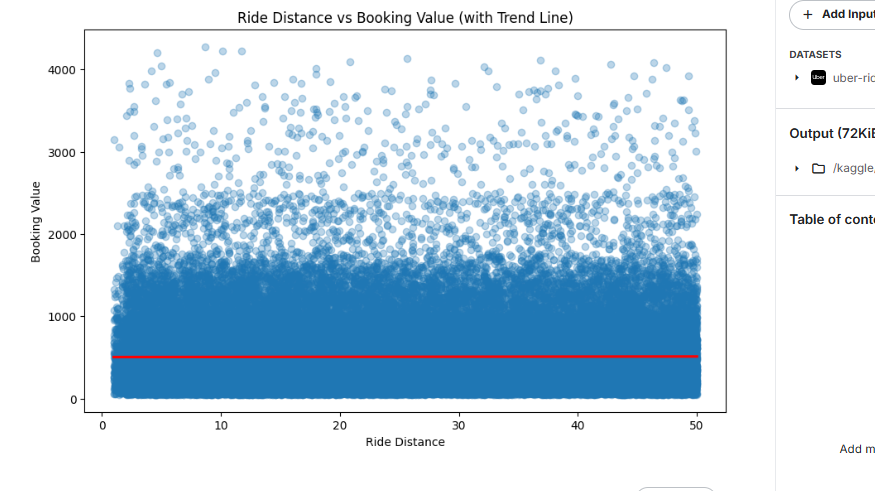

# 4.Ratings vs Booking Status 

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Booking Status', y='Driver Ratings', data=df, width=0.5, palette="Set2")
plt.title("Driver Ratings vs Booking Status")#Given by the passenger (customer) to the driver after a ride.
plt.xticks(rotation=30)
plt.ylim(0,5)   # ratings usually between 0–5
plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(x='Booking Status', y='Customer Rating', data=df, width=0.5, palette="Set3")
plt.title("Customer Ratings vs Booking Status")#Given by the driver to the passenger (customer) after a ride.
plt.xticks(rotation=30)
plt.ylim(0,5)   # ratings usually between 0–5
plt.show()



Both drivers and customers receive ratings **only on completed rides**, and in both cases ratings are **consistently high (mostly above 4)** with a few low outliers.


# 5.Ride Distance vs Vehicle Type

In [ ]:
def plot_box(cat_col, num_col):
    plt.figure(figsize=(10,5))
    sns.boxplot(x=cat_col, y=num_col, data=df)
    plt.xticks(rotation=45)
    plt.title(f"{num_col} by {cat_col}")
    plt.show()


In [ ]:

plot_box('Vehicle Type', 'Ride Distance')


The plot shows that ride distances are spread similarly across all vehicle types, with most trips around 20–25 km regardless of the vehicle chosen.

# 6.Correlation Analysis

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
# Show unique values (only first 20 if too many)
print(df['Incomplete Rides'].unique()[:20])

# Or show which rows are not numeric
mask = pd.to_numeric(df['Incomplete Rides'], errors='coerce').isna()
print(df.loc[mask, 'Incomplete Rides'].unique())


In [ ]:
cols_to_check = ['Cancelled Rides by Customer', 
                 'Cancelled Rides by Driver', 
                 'Incomplete Rides']

for col in cols_to_check:
    bad_vals = df.loc[pd.to_numeric(df[col], errors='coerce').isna(), col].unique()
    print(f"{col}: {bad_vals}")


In [ ]:
df.isnull().values.any()

# Data Cleaning

In [ ]:
cols_to_check = ['Cancelled Rides by Customer', 
                 'Cancelled Rides by Driver', 
                 'Incomplete Rides']

for col in cols_to_check:
    bad_vals = df.loc[pd.to_numeric(df[col], errors='coerce').isna(), col].unique()
    print(f"{col}: {bad_vals[:10]}")


In [ ]:
df.drop(['Cancelled Rides by Customer', 
         'Cancelled Rides by Driver', 
         'Incomplete Rides'], axis=1, inplace=True)


In [ ]:
df.head(20)

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
num_cols = df.select_dtypes(include=['int64','float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns


In [ ]:
num_cols = ['Avg VTAT', 'Avg CTAT', 'Booking Value', 
            'Ride Distance', 'Driver Ratings', 'Customer Rating']

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [ ]:
print(df[num_cols].dtypes)

      

In [ ]:
print(cat_cols)

In [ ]:
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna("Unknown")


In [ ]:
print(df.isnull().sum())


In [ ]:
from sklearn.preprocessing import LabelEncoder

cat_cols = df.select_dtypes(include=['object']).columns

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le


# Making the model ready

extracting features and selecting target

In [ ]:
target = 'Booking Value'
X = df.drop(columns=[target])   # all features except Booking Value
y = df[target]


Train-test spliting

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))
